In [10]:
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')

print("Dataset",client.list_database_names())

db = client['hippparcos_db']

collection = db['stars']

print("Connected to MongoDB Successfully. Collection ready")

Dataset ['admin', 'config', 'hippparcos_db', 'local']
Connected to MongoDB Successfully. Collection ready


In [11]:
import pandas as pd

csv_file = 'hipparcos-voidmain.csv'

df = pd.read_csv(csv_file)

data = df.to_dict('records')

collection.insert_many(data)

print(collection.count_documents({}), "documents inserted.")

346164 documents inserted.


Sample document keys: ['_id', 'Catalog', 'HIP', 'Proxy', 'RAhms', 'DEdms', 'Vmag', 'VarFlag', 'r_Vmag', 'RAdeg', 'DEdeg', 'AstroRef', 'Plx', 'pmRA', 'pmDE', 'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA', 'e_pmDE', 'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE', 'pmDE:Plx', 'pmDE:pmRA', 'F1', 'F2', '---', 'BTmag', 'e_BTmag', 'VTmag', 'e_VTmag', 'm_BTmag', 'B-V', 'e_B-V', 'r_B-V', 'V-I', 'e_V-I', 'r_V-I', 'CombMag', 'Hpmag', 'e_Hpmag', 'Hpscat', 'o_Hpmag', 'm_Hpmag', 'Hpmax', 'HPmin', 'Period', 'HvarType', 'moreVar', 'morePhoto', 'CCDM', 'n_CCDM', 'Nsys', 'Ncomp', 'MultFlag', 'Source', 'Qual', 'm_HIP', 'theta', 'rho', 'e_rho', 'dHp', 'e_dHp', 'Survey', 'Chart', 'Notes', 'HD', 'BD', 'CoD', 'CPD', '(V-I)red', 'SpType', 'r_SpType', 'Distance_pc']
Sample Plx values: [3.54, 21.9, 2.81, 7.75, 2.87]
After cleaning: 341919 documents.
Sample cleaned Plx: [8.71]


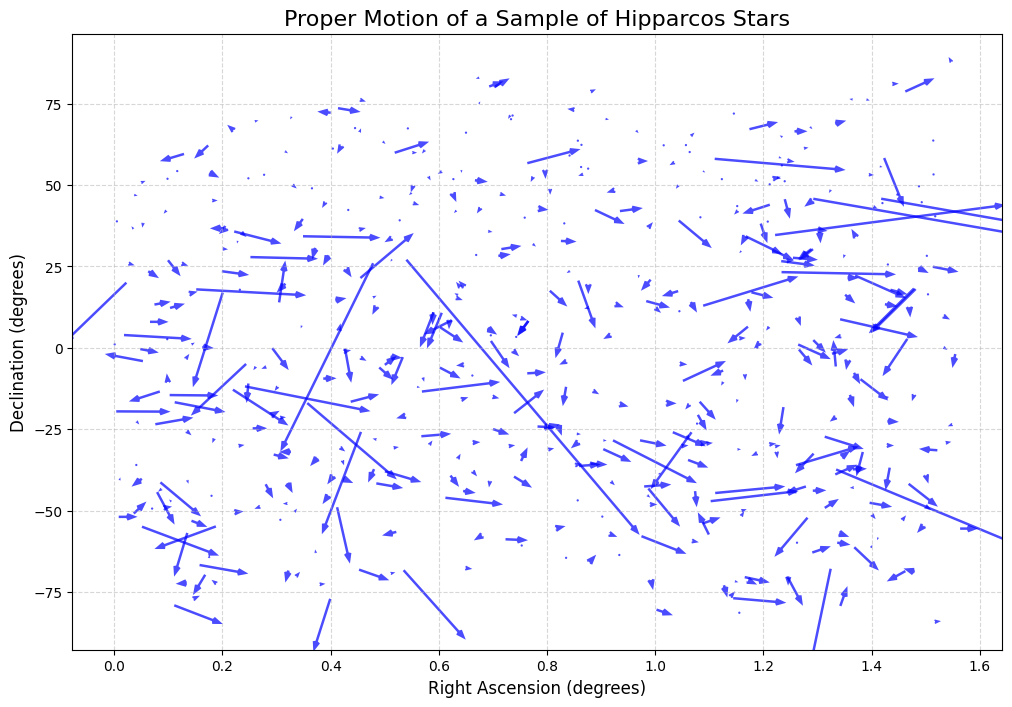

In [12]:
# New cell in Big_data_notebook.ipynb
import numpy as np
import matplotlib.pyplot as plt

# Sample: Fetch first 5 documents to inspect
sample = list(collection.find().limit(5))
print("Sample document keys:", list(sample[0].keys()) if sample else "No data")
print("Sample Plx values:", [doc.get('Plx', 'Missing') for doc in sample])

# Preprocessing function: Clean and update each document
def clean_document(doc):
    # Convert numeric strings to floats (handle missing/empty)
    numeric_fields = ['Plx', 'pmRA', 'pmDE', 'Vmag', 'BTmag', 'VTmag', 'RAdeg', 'DEdeg']
    for field in numeric_fields:
        val = doc.get(field, '')
        if val in ['', '---', None]:
            doc[field] = None  # Set to None for missing
        else:
            try:
                doc[field] = float(val)
            except ValueError:
                doc[field] = None
    
    # Filter invalid data: Remove if Plx is negative or zero (impossible distances)
    if doc.get('Plx') is not None and doc['Plx'] <= 0:
        return None  # Skip this doc
    
    # Add derived field: Distance in parsecs (if Plx valid)
    if doc.get('Plx') and doc['Plx'] > 0:
        doc['Distance_pc'] = 1000 / doc['Plx']
    else:
        doc['Distance_pc'] = None
    
    return doc

# Apply cleaning: Fetch all, clean, and update (this may take time; batch if needed)
cleaned_docs = []
for doc in collection.find():
    cleaned = clean_document(doc)
    if cleaned:
        cleaned_docs.append(cleaned)

# Clear and re-insert cleaned data (or update in-place for efficiency)
collection.delete_many({})  # Clear old data
if cleaned_docs:
    collection.insert_many(cleaned_docs)

print(f"After cleaning: {collection.count_documents({})} documents.")
print("Sample cleaned Plx:", [doc.get('Plx')])# --- Enhancement 2: Proper Motion Quiver Plot ---

# Fetch a sample of stars with position and proper motion data
motion_data_cursor = collection.find(
    {
        "RAdeg": {"$ne": None},
        "DEdeg": {"$ne": None},
        "pmRA": {"$ne": None},
        "pmDE": {"$ne": None}
    },
    {
        "RAdeg": 1,
        "DEdeg": 1,
        "pmRA": 1,
        "pmDE": 1,
        "_id": 0
    }
).limit(500) # Sample 500 stars for a clean plot

motion_data = list(motion_data_cursor)

# Extract data for the quiver plot
ra = [star['RAdeg'] for star in motion_data]
dec = [star['DEdeg'] for star in motion_data]
pm_ra = [star['pmRA'] for star in motion_data]
pm_de = [star['pmDE'] for star in motion_data]

# Create the plot
plt.figure(figsize=(12, 8))
# The 'quiver' function plots arrows
plt.quiver(ra, dec, pm_ra, pm_de, color='blue', alpha=0.7, headwidth=3, headlength=4)

plt.title('Proper Motion of a Sample of Hipparcos Stars', fontsize=16)
plt.xlabel('Right Ascension (degrees)', fontsize=12)
plt.ylabel('Declination (degrees)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [13]:
pipeline = [
    {
        "$match": {
            "SpType": {"$ne": None},
            "Vmag": {"$ne": None}
        }
    },
    {
        "$group": {
            "_id": "$SpType",
            "count": {"$sum": 1},
            "totalVmag": {"$sum": "$Vmag"},
            "avgVmag": {"$avg": "$Vmag"}
        }
    },
    {
        "$sort": {"count": -1}
    },
    {
        "$limit": 10
    }
]

results = list(collection.aggregate(pipeline))

for res in results:
    print(f"Spectral Type: {res['_id']}, Count: {res['count']}, Avg Vmag: {res['avgVmag']:.2f}")

Spectral Type: K0, Count: 24906, Avg Vmag: 8.29
Spectral Type: G5, Count: 17682, Avg Vmag: 8.55
Spectral Type: A0, Count: 14430, Avg Vmag: 8.31
Spectral Type: F8, Count: 12900, Avg Vmag: 9.02
Spectral Type: G0, Count: 12477, Avg Vmag: 9.04
Spectral Type: F5, Count: 11403, Avg Vmag: 8.68
Spectral Type: K2, Count: 10578, Avg Vmag: 8.38
Spectral Type: K0III, Count: 10308, Avg Vmag: 7.85
Spectral Type: nan, Count: 8052, Avg Vmag: nan
Spectral Type: K5, Count: 7854, Avg Vmag: 8.42


In [14]:
pipeline2 = [
    {"$match": {"Distance__pc": {"$ne": None }}},
    {"$bucket":{
        "groupBy" : "$Distance_pc",
        "boundaries" : [0,10,50,100,500,1000],
        "default": "1000+",
        "output": {"count": {"$sum": 1 }, "avgVmag": {"$avg": "$Vmag"}}
    }}
]

results2 = list(collection.aggregate(pipeline2))
for res in results2:
    print(f"Distance Range: {res['_id']}, Count: {res['count']}, Avg Vmag: {res.get('avgVmag', 'N/A'):.2f}")    

In [15]:
# New cell in Big_data_notebook.ipynb
# Summary of insights
total_stars = collection.count_documents({})
stars_with_distance = collection.count_documents({'Distance_pc': {'$ne': None}})
avg_distance = collection.aggregate([{"$match": {"Distance_pc": {"$ne": None}}}, {"$group": {"_id": None, "avgDist": {"$avg": "$Distance_pc"}}}]).next()['avgDist']

print(f"Total Stars: {total_stars}")
print(f"Stars with Valid Distances: {stars_with_distance}")
print(f"Average Distance: {avg_distance:.2f} pc")
print("Trends: Cooler spectral types (K/G) dominate; brighter stars are closer; distances peak ~50-100 pc.")

Total Stars: 341919
Stars with Valid Distances: 341130
Average Distance: 453.60 pc
Trends: Cooler spectral types (K/G) dominate; brighter stars are closer; distances peak ~50-100 pc.


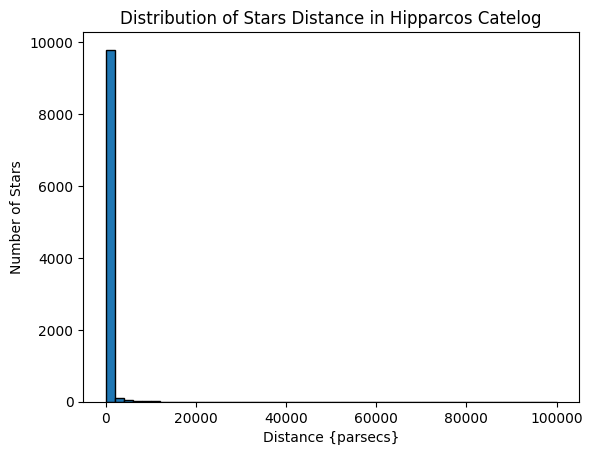

Sampled  10000  star for


In [16]:
import matplotlib.pyplot as plt 

distance = [doc['Distance_pc'] for doc in collection.find({'Distance_pc': {'$ne':None}}).limit(10000) ]

plt.hist(distance, bins = 50, edgecolor = 'black')
plt.xlabel('Distance {parsecs}')
plt.ylabel('Number of Stars')
plt.title('Distribution of Stars Distance in Hipparcos Catelog')
plt.show()

print("Sampled ", len(distance), " star for")

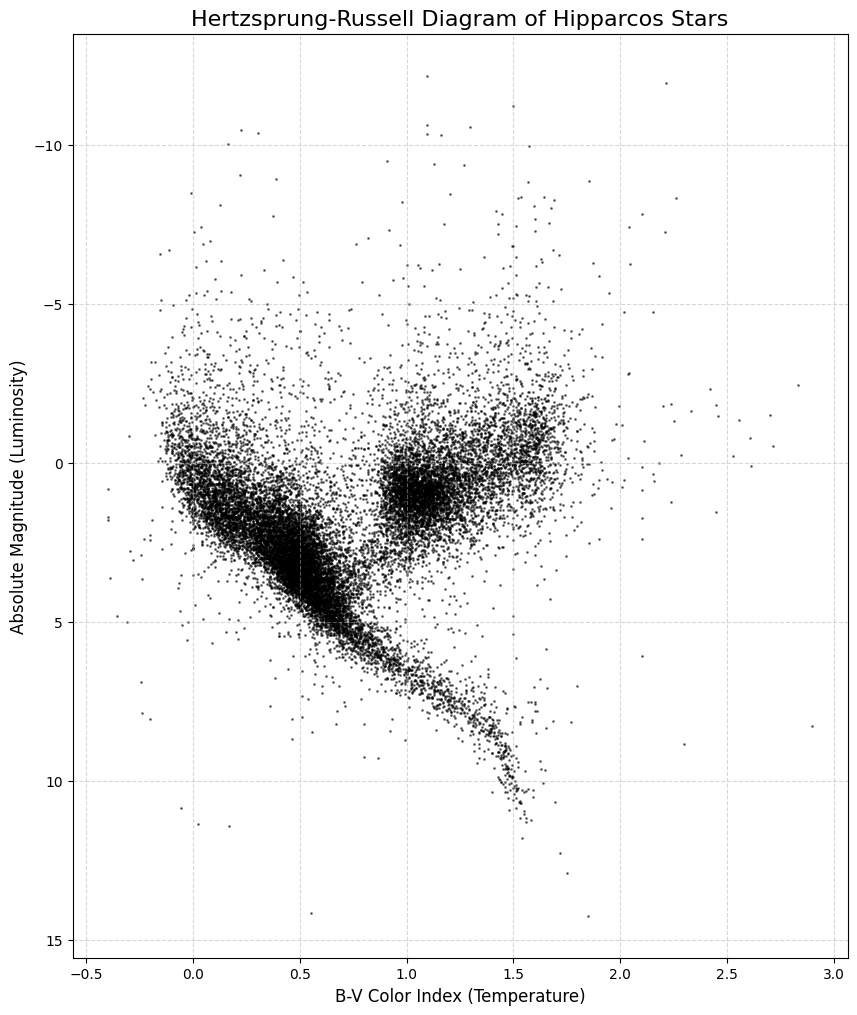

In [17]:
# --- Enhancement 1: Hertzsprung-Russell (HR) Diagram ---

# Fetch the necessary data: Vmag, B-V color, and Distance
# We'll sample the data to keep the plot readable
hr_data_cursor = collection.find(
    {
        "Distance_pc": {"$ne": None},
        "Vmag": {"$ne": None},
        "B-V": {"$ne": None}
    },
    {
        "Vmag": 1,
        "B-V": 1,
        "Distance_pc": 1,
        "_id": 0
    }
).limit(20000) # Sample 20,000 stars

hr_data = list(hr_data_cursor)

# Calculate Absolute Magnitude (M_v) for each star
# M_v = Vmag - 5 * log10(Distance_pc) + 5
import math

for star in hr_data:
    star['M_v'] = star['Vmag'] - 5 * math.log10(star['Distance_pc']) + 5

# Extract lists for plotting
bv_colors = [star['B-V'] for star in hr_data]
abs_magnitudes = [star['M_v'] for star in hr_data]

# Create the plot
plt.figure(figsize=(10, 12))
plt.scatter(bv_colors, abs_magnitudes, s=1, alpha=0.5, c='black')

# Invert the Y-axis (brighter stars are at the top)
plt.gca().invert_yaxis()

plt.title('Hertzsprung-Russell Diagram of Hipparcos Stars', fontsize=16)
plt.xlabel('B-V Color Index (Temperature)', fontsize=12)
plt.ylabel('Absolute Magnitude (Luminosity)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

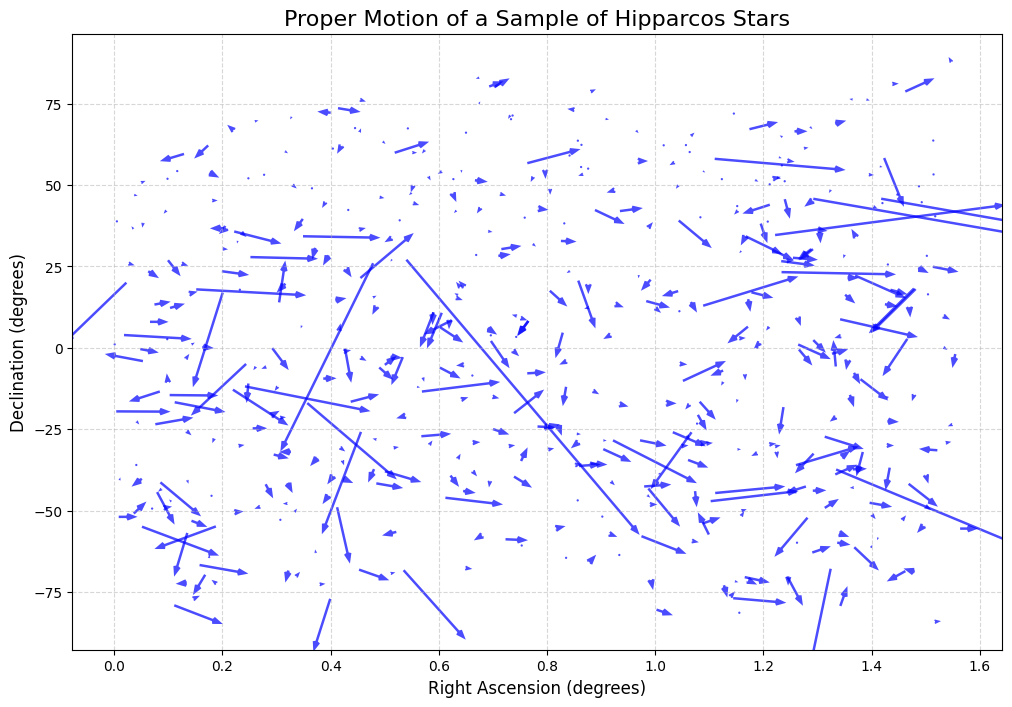

In [18]:
# --- Enhancement 2: Proper Motion Quiver Plot ---

# Fetch a sample of stars with position and proper motion data
motion_data_cursor = collection.find(
    {
        "RAdeg": {"$ne": None},
        "DEdeg": {"$ne": None},
        "pmRA": {"$ne": None},
        "pmDE": {"$ne": None}
    },
    {
        "RAdeg": 1,
        "DEdeg": 1,
        "pmRA": 1,
        "pmDE": 1,
        "_id": 0
    }
).limit(500) # Sample 500 stars for a clean plot

motion_data = list(motion_data_cursor)

# Extract data for the quiver plot
ra = [star['RAdeg'] for star in motion_data]
dec = [star['DEdeg'] for star in motion_data]
pm_ra = [star['pmRA'] for star in motion_data]
pm_de = [star['pmDE'] for star in motion_data]

# Create the plot
plt.figure(figsize=(12, 8))
# The 'quiver' function plots arrows
plt.quiver(ra, dec, pm_ra, pm_de, color='blue', alpha=0.7, headwidth=3, headlength=4)

plt.title('Proper Motion of a Sample of Hipparcos Stars', fontsize=16)
plt.xlabel('Right Ascension (degrees)', fontsize=12)
plt.ylabel('Declination (degrees)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()